In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
import random
from scipy.optimize import root_scalar
from scipy.stats import truncnorm
import itertools
from itertools import permutations, combinations
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
#!pip install lifelines
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

In [ ]:
# inputs: 
# FV
# risk
# position (1 hot encoded)
# hs indicator

# outputs: 
# what pick number the player was selected at 
# more specifically, probability that the player was selected at each number 

# model: CoxPH survivorship model, where getting drafted is "death" 

In [7]:
training_data = pd.read_csv('training_data')
df_4 = pd.read_csv('df_4')

In [9]:
# coxPH model

# data
x = training_data[['position_1B', 'position_C', 'position_IF', 'position_LHP', 'position_RHP', 'position_SS', 'hs','fv','risk','number']].copy() # covariates and y
x['event'] = True # because nobody is censored 

cph = CoxPHFitter()
cph.fit(x, duration_col='number', event_col='event')

# Step 3: View summary
cph.print_summary() # concordance of 0.78 is pretty good!

<lifelines.CoxPHFitter: fitted with 437 total observations, 0 right-censored observations>
             duration col = 'number'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 437
number of events observed = 437
   partial log-likelihood = -2093.98
         time fit was run = 2025-06-18 19:47:48 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
position_1B  -0.31      0.73      0.29           -0.87            0.26                0.42                1.29
position_C   -0.63      0.53      0.25           -1.12           -0.14                0.33                0.87
position_IF  -0.23      0.80      0.18           -0.58            0.12                0.56                1.13
position_LHP -0.19      0.83      0.18           -0.54            0.17                0.58                1.19
position_RHP -0.36      0.69      0.15           -0.65           -0.08                0.52                0.93
position_SS   0.09      1.09      0.19           -0.29            0.47                0.75                1.60
hs            0.02      1.02      0.12           -0.21            0.25                0.81                1.29
fv            0.24      1.27      0.02            0.21            0.27                1.23                1.31
risk         -0.00      1.00      0.00           -0.01            0.00                0.99                1.00

              cmp to     z      p  -log2(p)
covariate                                  
position_1B     0.00 -1.07   0.28      1.82
position_C      0.00 -2.50   0.01      6.35
position_IF     0.00 -1.29   0.20      2.34
position_LHP    0.00 -1.02   0.31      1.70
position_RHP    0.00 -2.47   0.01      6.20
position_SS     0.00  0.46   0.65      0.63
hs              0.00  0.20   0.84      0.24
fv              0.00 15.12 <0.005    169.09
risk            0.00 -0.76   0.45      1.15
---
Concordance = 0.78
Partial AIC = 4205.96
log-likelihood ratio test = 259.82 on 9 df
-log2(p) of ll-ratio test = 166.35

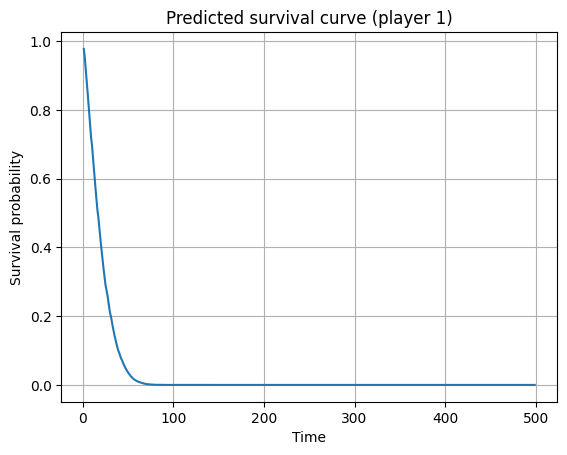

prob: 0      0.302123
1      0.297799
2      0.333069
3      0.099712
4      0.328455
         ...   
151    0.016058
152    0.016058
153    0.016058
154    0.030965
155    0.031668
Name: 10.0, Length: 156, dtype: float64


In [21]:
# apply model to testing data and plot: 
x_test = df_4[['position_1B', 'position_C', 'position_IF', 'position_LHP', 'position_RHP', 'position_SS', 'hs','fv','risk']].copy() # covariates and y

survivalfxn = cph.predict_survival_function(x_test)

survivalfxn.iloc[:, 0].plot()
plt.title("Predicted survival curve (player 1)")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.grid()
plt.show()

In [37]:
# evaluating the C-index on teh test set

from lifelines.utils import concordance_index

testing_df = df_4[['number','position_1B', 'position_C', 'position_IF', 'position_LHP', 'position_RHP', 'position_SS', 'hs','fv','risk']].copy() # covariates and y
testing_df['event'] = True # no censoring

c_index = concordance_index(
    event_times=testing_df['number'],
    predicted_scores=-cph.predict_partial_hazard(x_test),  # minus because higher hazard is worse
    event_observed=testing_df['event']
)
print(f"Test C-index: {c_index:.3f}") # Really good c index of almost 0.8!

Test C-index: 0.787


In [31]:
survivalfxn # each column represents a player, each row represetns a day 

# first player, 5th pick: 
player = 1
pick = 5

print(survivalfxn.loc[pick,player-1])

0.8570814155070837


In [101]:
print(survivalfxn.index)

Index([  1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,   9.0,  10.0,
       ...
       322.0, 336.0, 337.0, 338.0, 343.0, 347.0, 351.0, 385.0, 426.0, 499.0],
      dtype='float64', length=199)


In [81]:
survivalfxn.loc[190,player]

np.float64(4.093566864848517e-15)

In [137]:
# preparing the datframe of draft pick choices 

picks = pd.read_csv('2024picks.csv')

grouped = picks.groupby("Team")["Number"].agg(list).reset_index()

grouped.to_csv('picks')

grouped.head()

,Team,Number
0,ARI,"[29, 31, 35, 64, 102, 132, 164, 194]"
1,ATL,"[24, 62, 99, 129, 161]"
2,BAL,"[22, 32, 61, 97, 127, 160]"
3,BOS,"[12, 50, 86, 115, 148]"
4,CHC,"[14, 54, 90, 120, 153]"


In [192]:
# helpful functions for data engineering

def create_scenario(team):
    output_df = pd.DataFrame()
    output_df['name'] = df_4['name'].copy()

    picks = grouped.loc[grouped["Team"] == team, "Number"].values[0].copy()
    
    for pick in picks: 
        if pick <= 136:   # we are only going through round 4C based on our data 
            new_column = []
            for player in range(df_4.shape[0]):
                new_column.append(survivalfxn.loc[pick,player]) #pick 
            new_column_series =  pd.Series(new_column)
            output_df = pd.concat([output_df, new_column_series], axis=1)        
        
    # Output dataframe where: 
    # first column for both name: df_4['name']
    # For first df: columns 2 through k are the probabilities that each player is still available at the pick, by print(survivalfxn.loc[pick,player])
    # then, we convert columns 2 through n into binaries by random sampling 
    # NOTE: start earlier, if we ever get a zero, the later ones all must be zero as well 

    return output_df

bonuses = pd.read_csv('signing_bonus_df.csv')
def estimate_bonuses(team):

    picks2 = grouped.loc[grouped["Team"] == team, "Number"].values[0].copy()
    picks2.append(0)

    picks2 = [x for x in picks2 if x <= 136]

    selected = bonuses.iloc[:, sorted(picks2)]

    return selected 

def real_availabilities(team): 

    df_players = pd.DataFrame()
    df_players['name'] = df_4['name'].copy()

    picks3 = grouped.loc[grouped["Team"] == team, "Number"].values[0].copy()
    
    for pick in picks3:
        if pick <= 136: 
            new_col = []
            for player in range(df_4.shape[0]):
                is_avail = 0 
                if df_4.loc[player,'number'] >= pick:
                    is_avail = 1
                new_col.append(is_avail)
            new_col_s = pd.Series(new_col)
            df_players = pd.concat([df_players, new_col_s], axis =1)


    return df_players
    

In [195]:
ari_probs = create_scenario('ARI')
ari_bonus = estimate_bonuses('ARI')
ari_real = real_availabilities('ARI')
ari_probs

,name,0,0,0,0,0,0
0,Travis Bazzana,0.225826,0.198257,0.142733,0.006779,2.157535e-06,1.556097e-10
1,Chase Burns,0.231671,0.203843,0.147585,0.007386,2.699312e-06,2.293271e-10
2,Charlie Condon,0.187194,0.161665,0.111665,0.003612,4.164158e-07,9.023014e-12
3,Nick Kurtz,0.647580,0.623421,0.566383,0.232635,2.215351e-02,1.367565e-03
4,Hagen Smith,0.192610,0.166757,0.115911,0.003974,5.347219e-07,1.391042e-11
...,...,...,...,...,...,...,...
151,Mason Marriott,0.935227,0.929762,0.916114,0.798717,5.559063e-01,3.619060e-01
152,Dennis Colleran,0.935227,0.929762,0.916114,0.798717,5.559063e-01,3.619060e-01
153,Brock Moore,0.935227,0.929762,0.916114,0.798717,5.559063e-01,3.619060e-01
154,Luke Hayden,0.877994,0.868054,0.843467,0.646173,3.195492e-01,1.387876e-01


In [198]:
# going to write a loop that makes all of these files and writes them so they can be used in the optimization (Julia)

for team in grouped['Team']:
    #print(team)
    probs = create_scenario(team)
    bonus = estimate_bonuses(team)
    real = real_availabilities(team)
    
    probs.to_csv(f'team_data/{team}_probs.csv', index=False)
    bonus.to_csv(f'team_data/{team}_bonus.csv', index=False)
    real.to_csv(f'team_data/{team}_real.csv', index=False)
    